In [1]:
import torch
import logging
import pandas as pd

In [2]:
# Check the gfx resources

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Mon Jun 21 17:37:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:21:00.0 Off |                  N/A |
|100%   28C    P8    14W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:22:00.0 Off |                  N/A |
|100%   

In [5]:
# empty the gfx cache if needed

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Check the model

In [7]:
from transformers import *
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

fill_mask = pipeline(
    "fill-mask",
    model="allenai/scibert_scivocab_uncased",
    tokenizer="allenai/scibert_scivocab_uncased"
)

MASK_TOKEN = tokenizer.mask_token

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# masked sentence

In [9]:
'''
The fourth one is a Logistic Regression model built using Term Frequency Inverse Document Frequency (TF-IDF) features.
'''

fill_mask("The fourth one is a Logistic {} model.".format(MASK_TOKEN))

[{'sequence': 'the fourth one is a logistic regression model.',
  'score': 0.9676188230514526,
  'token': 3089,
  'token_str': 'regression'},
 {'sequence': 'the fourth one is a logistical model.',
  'score': 0.003718762891367078,
  'token': 120,
  'token_str': '##al'},
 {'sequence': 'the fourth one is a logistic logistic model.',
  'score': 0.001894849818199873,
  'token': 7312,
  'token_str': 'logistic'},
 {'sequence': 'the fourth one is a logistic mixed model.',
  'score': 0.0009710376616567373,
  'token': 4055,
  'token_str': 'mixed'},
 {'sequence': 'the fourth one is a logistic growth model.',
  'score': 0.0009649104322306812,
  'token': 1503,
  'token_str': 'growth'}]

In [10]:
'''
A total synthesis is the complete chemical synthesis of complex organic molecules from simple, commercially available petrochemical or natural precursors.
'''
fill_mask("A total synthesis is the complete chemical synthesis of complex {} molecules from simple, \
commercially available petrochemical or natural precursors.".format(MASK_TOKEN))

[{'sequence': 'a total synthesis is the complete chemical synthesis of complex organic molecules from simple, commercially available petrochemical or natural precursors.',
  'score': 0.9026375412940979,
  'token': 4756,
  'token_str': 'organic'},
 {'sequence': 'a total synthesis is the complete chemical synthesis of complex bioactive molecules from simple, commercially available petrochemical or natural precursors.',
  'score': 0.01477374229580164,
  'token': 20052,
  'token_str': 'bioactive'},
 {'sequence': 'a total synthesis is the complete chemical synthesis of complex biological molecules from simple, commercially available petrochemical or natural precursors.',
  'score': 0.012415599077939987,
  'token': 3157,
  'token_str': 'biological'},
 {'sequence': 'a total synthesis is the complete chemical synthesis of complex small molecules from simple, commercially available petrochemical or natural precursors.',
  'score': 0.007356335408985615,
  'token': 952,
  'token_str': 'small'},
 

# Load trained transformer model and set up a classification model

In [11]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [17]:
model_args = ClassificationArgs()
model_args.num_train_epochs = 10  #SET the number of epochs, 40-50 should be enough (depends on a dataset, plot the loss to see)
model_args.no_save = True
model_args.overwrite_output_dir = True

model = ClassificationModel(
    "bert",
    "allenai/scibert_scivocab_uncased",
    #use_cuda=False,
    args=model_args
)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

# Prepare the data

In [13]:
train_df = pd.read_csv(r'./data/train.csv', header=None, nrows=10000)
eval_df = pd.read_csv(r'./data/test.csv', header=None, nrows=5000)
train_df.columns = ['labels', 'text']
eval_df.columns = ['labels', 'text']

train_df['labels'] = (train_df['labels'] == 2).astype(int)
eval_df['labels'] = (eval_df['labels'] == 2).astype(int)
train_df = train_df[['text', 'labels']]
eval_df = eval_df[['text', 'labels']]

train_df

,text,labels
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1
...,...,...
9995,Worst Japanese food in town! I go here about o...,0
9996,Yum!\n\nIt's been a family tradition to go her...,1
9997,I came here after graduating back in May and m...,0
9998,"Welcome to Restaurant Hell, courtesy of Kamaku...",0


# Train the model

In [18]:
model.train_model(train_df)

/home/clarovak/.conda/envs/trf/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:936: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


(12500, 0.13369883965730667)

# Evaluate the model

In [19]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [31]:
predictions, raw_outputs = model.predict(eval_df['text'].to_list())

# RESULTS

In [20]:
result

{'mcc': 0.7789061752230676,
 'tp': 1944,
 'tn': 2510,
 'fp': 251,
 'fn': 295,
 'auroc': 0.9531383580946828,
 'auprc': 0.9385421683792254,
 'eval_loss': 0.9851429148674011}

In [51]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

mat = sklearn.metrics.confusion_matrix(eval_df['labels'] , predictions, normalize='true')
mat

array([[0.9, 0.1],
       [0.1, 0.9]])

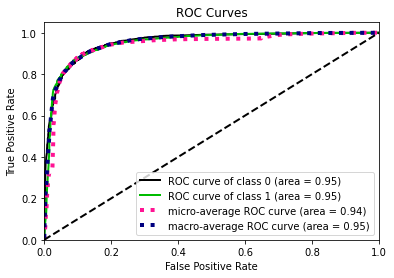

In [44]:
import scikitplot as skplt

skplt.metrics.plot_roc(eval_df['labels'], raw_outputs)
plt.show()

In [47]:
# Functions

,0,1
0,2510,251
1,295,1944


In [53]:
import itertools
import numpy as np

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=1) 

